# УСТАНОВКА

In [1]:
!pip install shap

# ПОДКЛЮЧАЕМ БИБЛИОТЕКИ

In [2]:
import numpy as np 
import pandas as pd
import time
import re
import math

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Embedding
from tensorflow.keras import utils
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import LambdaCallback, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
# from sklearn.metrics import mean_squared_error, mean_absolute_error
# from google.colab import files # Для загрузки своей картинки
from google.colab import drive

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from IPython.display import clear_output

import shap

In [3]:
print(shap.__version__)

0.39.0


In [4]:
!gdown --id '1kfqcWkMMoicCEbD8opoFZ9SSuC2uThSP'

Permission denied: https://drive.google.com/uc?id=1kfqcWkMMoicCEbD8opoFZ9SSuC2uThSP
Maybe you need to change permission over 'Anyone with the link'?


# НАСТРОЙКИ

In [5]:
CSV_PATH = '/content/flats_moscow.csv'

# ДАННЫЕ
Цены на квартиры в Москве
https://www.kaggle.com/hugoncosta/price-of-flats-in-moscow


*   **price:** - цена квартиры в $1000
*   **totsp:** - общая площадь квартиры, кв.м.
*   **livesp** - жилая площадь
*   **kitsp** - площадь кухни
*   **dist:** - расстояние до центра
*   **metrdist:** - расстояние до метро в минутах
*   **walk:** 1 – пешком от метро, 0 – на транспорте
*   **brick:** 1 – кирпичный, монолит ж/б, 0 – другой
*   **floor:** 1 – этаж кроме первого и последнего, 0 – иначе.




In [6]:
# Загружаем файлы
# files.upload()

In [7]:
df = pd.read_csv(CSV_PATH, sep=',',index_col=0)
df

,price,totsp,livesp,kitsp,dist,metrdist,walk,brick,floor,code
1,81,58,40,6.0,12.5,7,1,1,1,3
2,75,44,28,6.0,13.5,7,1,0,1,6
3,128,70,42,6.0,14.5,3,1,1,1,3
4,95,61,37,6.0,13.5,7,1,0,1,1
5,330,104,60,11.0,10.5,7,0,1,1,3
...,...,...,...,...,...,...,...,...,...,...
2036,110,77,45,10.0,12.0,5,0,0,1,5
2037,95,60,43,6.0,9.0,5,0,0,1,4
2038,95,60,46,5.0,10.5,5,1,0,1,7
2039,129,76,48,10.0,12.5,5,0,0,1,3


# СМОТРИМ ВЫБРОСЫ

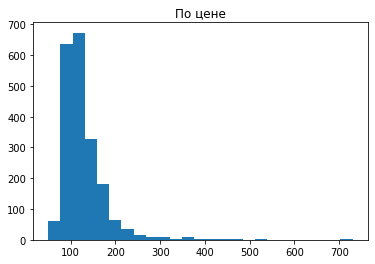

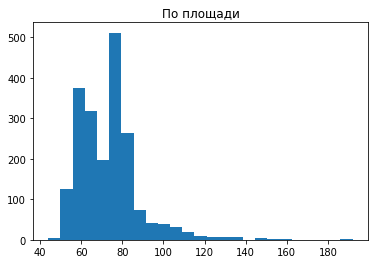

In [8]:
plt.hist(df['price'], bins=25)
plt.title('По цене')
plt.show()
plt.hist(df['totsp'], bins=25)
plt.title('По площади')
plt.show()

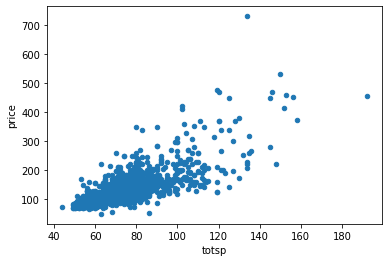

In [9]:
data = pd.concat([df['price'], df['totsp']], axis=1)
data.plot.scatter(x='totsp', y='price');

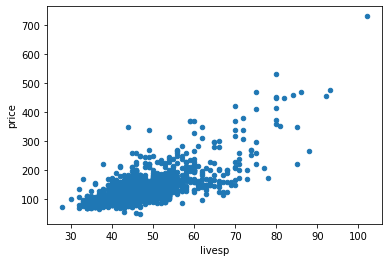

In [10]:
data = pd.concat([df['price'], df['livesp']], axis=1)
data.plot.scatter(x='livesp', y='price');

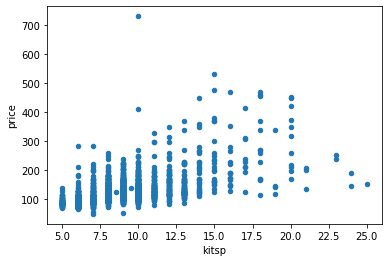

In [11]:
data = pd.concat([df['price'], df['kitsp']], axis=1)
data.plot.scatter(x='kitsp', y='price');

# КОРРЕЛЯЦИЯ

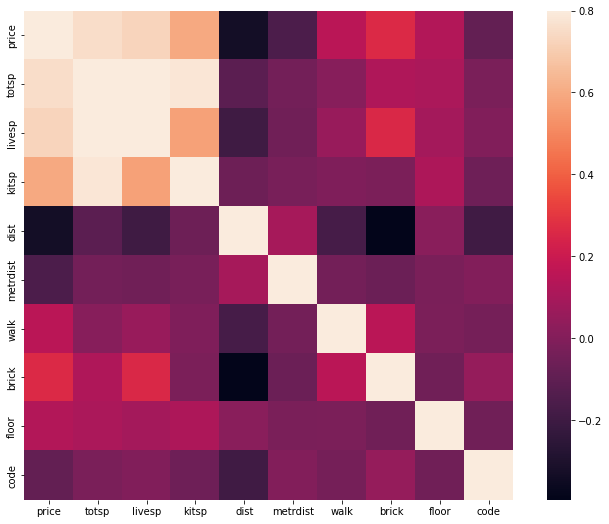

In [12]:
corrmat = df.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

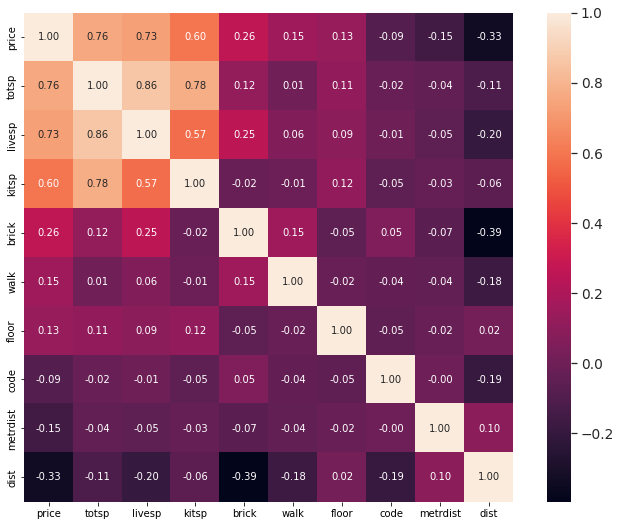

<Figure size 1080x648 with 0 Axes>

In [13]:
f, ax = plt.subplots(figsize=(12, 9))
k = 10
cols = corrmat.nlargest(k, 'price')['price'].index
cm = np.corrcoef(df[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.figure(figsize=(15, 9))
plt.show()

# КЛАСС

In [14]:
class Estate:
  def __init__(self, df):
    self.df = df
    self.x_train = ''
    self.y_train = ''

  # Расстояние до метро
  def dist_to_categorical(self, metrdist, walk):
    # Дистанции в категории
    if (metrdist < 3):
      dist = 1
    elif (metrdist < 6):
      dist = 2
    elif (metrdist < 10):
      dist = 3
    elif (metrdist < 15):
      dist = 4
    elif (metrdist < 20):
      dist = 5
    else:
      dist = 11

    # Индексы классов - пешком 1 - 5, на транспорте: 6 - 10, другое - 11
    distance = (1-walk)*5 + dist if dist != 11 else 11
    return utils.to_categorical(distance, 12)

  # Получаем строку данных, объединяя данные из столбцов  
  def get_row(self, row):
    metro_dist = self.dist_to_categorical(row[6], row[7])
    x = []
    x.extend([float(row[2])])  # totsp - общая площадь квартиры
    x.extend([float(row[3])])  # livesp - жилая площадь
    x.extend([float(row[4])])  # kitsp - площадь кухни
    x.extend([float(row[5])])
    x.extend(metro_dist)
    x.extend([float(row[8])])
    x.extend([float(row[9])])
    y = row[1]
    if row[2] < 20 or row[2] > 300:  # Отсекаем выбросы по общей площади
      y = False
    if y > 140:  # Отсекаем выбросы по цене
      y = False
    return x, y

  # Получаем данные
  def get_data(self, df):
    x_list = []
    y_list = []
    for i in range(df.shape[0]):
      x_data, y_data = self.get_row(df.iloc[i])
      if not y_data:
        continue
      x_list.append(x_data)
      y_list.append(y_data)
    x_train = np.array(x_list)
    y_train = np.array(y_list)
    self.x_train = x_train
    self.y_train = y_train
    return x_train, y_train

  # Нормируем площадь в x_data
  def normal(self, x_data):
    x_totsp_scaler = StandardScaler() # Создаём нормировщик нормальным распределением
    x_totsp_scaler.fit(x_data[:,1].reshape(-1, 1))
    x_data_n = x_data.copy()
    x_data_n[:, 1] = x_totsp_scaler.transform(x_data[:, 1].reshape(-1, 1)).flatten()  # Нормализуем данные нормировщиком
    return x_data

  # Интерпритация весов датасета
  def interpretation(self, model, x_train):
    explainer = shap.GradientExplainer(model, x_train)
    shap_values = explainer.shap_values(x_train)
    plt.title('Важность параметров, влияющих на стоимость')
    feature_names = ['Площадь квартиры', 'Жилая площадь', 'Площадь кухни', 'Расстояние до центра', 'Удалённость от метро, зона 1', 
      'Удалённость от метро, зона 2', 'Удалённость от метро, зона 3', 'Удалённость от метро, зона 4',
      'Удалённость от метро, зона 5', 'Удалённость от метро, зона 6', 'Удалённость от метро, зона 7',
      'Удалённость от метро, зона 8', 'Удалённость от метро, зона 9', 'Удалённость от метро, зона 10',
      'Удалённость от метро, зона 11', 'Удалённость от метро, прочее', 'Дом кирпичный, монолит, другой', 
      'Этаж кроме первого и последнего, 0 – иначе']
    plt.grid()
    shap.summary_plot(shap_values, x_train, plot_type='bar', feature_names=feature_names)

  # Получение курса валюты за указанный день
  def get_rate(charcode='USD', date='01/01/2020'):
    response = requests.get("http://www.cbr.ru/scripts/XML_daily.asp", {"date_req": date})
    soup = BeautifulSoup(response.content, 'lxml')
    node = soup.find('charcode', text=charcode)
    # nominal_str = node.nextSibling.string  # Для случая, когда номинал > 1, например цена за 100 JPY
    # nominal = nominal_str.replace(',', '.')
    value_str = node.findNextSiblings('value')[0].string
    value = value_str.replace(',', '.')
    return value

  # Получаем курс валюты за указанный период
  def get_rate_list(charcode='USD', date_start='01/01/2020', date_end='01/02/2020'):
    day_current = date_start
    delta = timedelta(days=1)
    rate_list = []  # Курс валюты
    while day_current < date_end:
      day_current_format = day_current.strftime("%d/%m/%Y")
      rate = self.get_rate(charcode=CHARCODE, date=day_current_format)
      print(str(day_current), rate)
      rate_list.append([str(day_current), 1])
      day_current += delta
    return rate_list

# СОЗДАЁМ x_train, y_train, x_test, y_test

In [15]:
estate = Estate(df)
x_data, y_data = estate.get_data(df)

## Нормализуем данные

In [16]:
x_data_n = estate.normal(x_data)
print('x_data после нормализации', x_data_n.shape, x_data_n[0])

x_data после нормализации (2030, 18) [40.   6.  12.5  7.   0.   1.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   1.   3. ]


## x_train, y_train, x_test, y_test

In [17]:
x_train, x_test, y_train, y_test = train_test_split(x_data_n, y_data, test_size=0.1, random_state=12)

In [18]:
print('Размерность данных train:', x_train.shape, y_train.shape, 'test:', x_test.shape, y_test.shape)
print('Цены, минимум:', y_train.min(), 'максимум:', y_train.max())
print('Пример строки x_train:', x_train[0])

Размерность данных train: (1827, 18) (1827,) test: (203, 18) (203,)
Цены, минимум: 44.0 максимум: 136.0
Пример строки x_train: [39.  9.  6.  5.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  6.]


# МОДЕЛЬ

In [19]:
'''
model = Sequential()
model.add(Dense(256, activation='relu', input_shape=(x_train.shape[1],)))
model.add(Dropout(0.28))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.28))
model.add(Dense(1))
'''

"\nmodel = Sequential()\nmodel.add(Dense(256, activation='relu', input_shape=(x_train.shape[1],)))\nmodel.add(Dropout(0.28))\nmodel.add(Dense(256, activation='relu'))\nmodel.add(Dropout(0.28))\nmodel.add(Dense(1))\n"

In [20]:
x_input = Input(shape=(x_train.shape[1],), name='x_input')
x = Dense(256, activation='relu')(x_input)
x = BatchNormalization()(x)
x_1 = Dropout(0.2)(x)
x = Dense(128, activation='relu')(x_1)
x = BatchNormalization()(x)
x_2 = Dropout(0.1)(x)
x = Dense(64, activation='relu')(x_2)
x = BatchNormalization()(x)
x_3 = Dropout(0.1)(x)
x_conc = concatenate([x_1, x_2, x_3])
x_output = Dense(1, activation='relu')(x_conc)
model = Model(inputs=x_input, outputs=x_output)

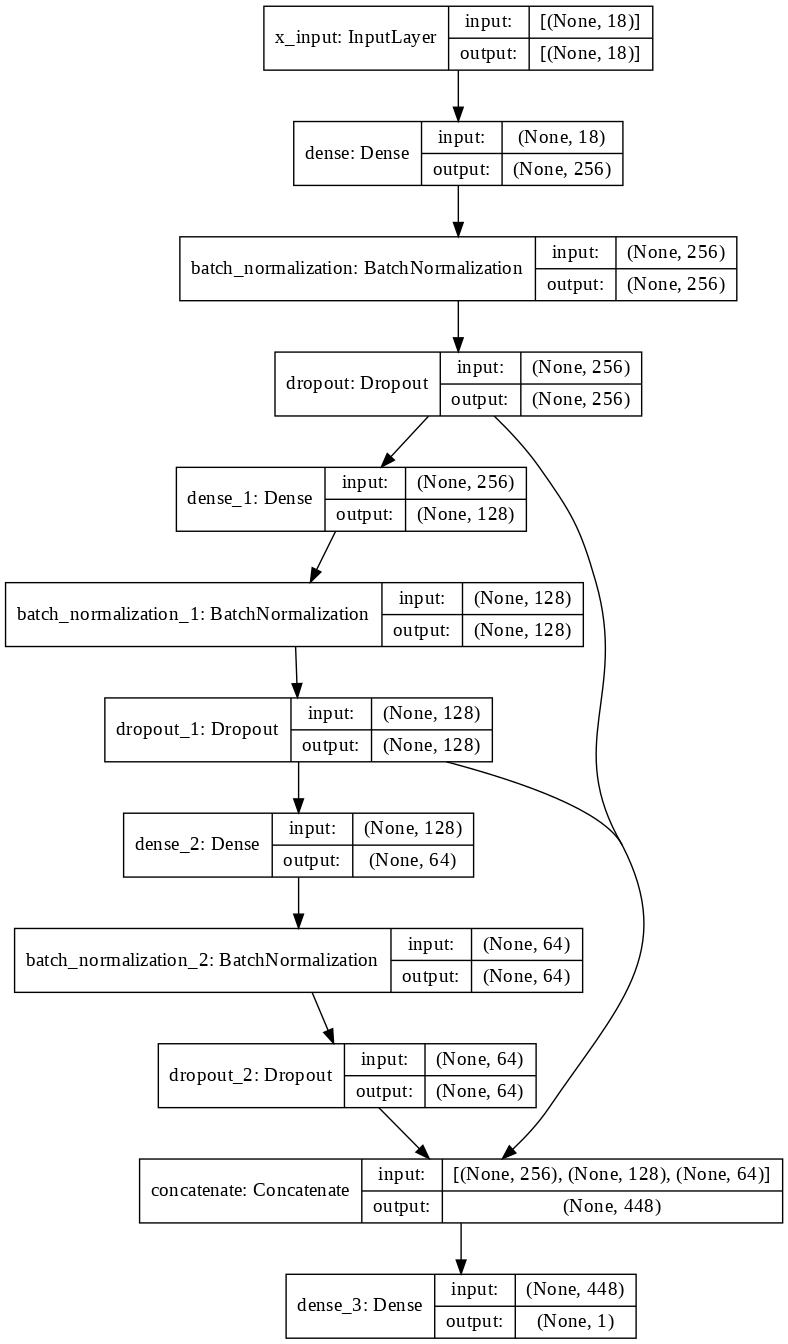

In [21]:
plot_model(model, show_shapes=True, expand_nested=True, show_layer_names=True, dpi=100)

# Callback

In [22]:
reduce_lr = ReduceLROnPlateau (
    monitor='val_loss', 
    factor=0.1, 
    patience=30, 
    verbose=1,
    mode='auto', 
    min_delta=0.0001, 
    cooldown=0, 
    min_lr=0.00001
)

In [23]:
model.compile(optimizer=Adam(learning_rate=1e-4), loss='mae')
history = model.fit(
	x_train, 
	y_train, 
	batch_size=64, 
	epochs=1000, 
	# validation_split=0.2,
  validation_data=(x_test, y_test),
	verbose=1,
	callbacks=[reduce_lr]
)

Epoch 1/1000
29/29 [==============================] - 1s 10ms/step - loss: 71.9526 - val_loss: 66.4440
Epoch 2/1000
29/29 [==============================] - 0s 4ms/step - loss: 71.2011 - val_loss: 63.3540
Epoch 3/1000
29/29 [==============================] - 0s 4ms/step - loss: 70.3599 - val_loss: 61.1551
Epoch 4/1000
29/29 [==============================] - 0s 4ms/step - loss: 69.5486 - val_loss: 60.0672
Epoch 5/1000
29/29 [==============================] - 0s 4ms/step - loss: 68.7577 - val_loss: 59.8576
Epoch 6/1000
29/29 [==============================] - 0s 4ms/step - loss: 67.9736 - val_loss: 60.1165
Epoch 7/1000
29/29 [==============================] - 0s 4ms/step - loss: 67.2384 - val_loss: 60.6609
Epoch 8/1000
29/29 [==============================] - 0s 4ms/step - loss: 66.4856 - val_loss: 61.0593
Epoch 9/1000
29/29 [==============================] - 0s 4ms/step - loss: 65.7932 - val_loss: 61.2240
Epoch 10/1000
29/29 [==============================] - 0s 4ms/step - loss: 65.036

[]

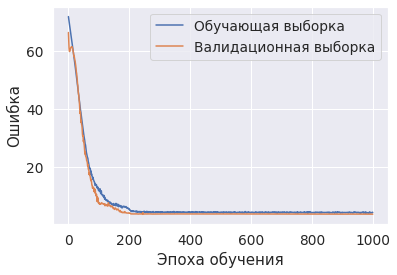

In [24]:
plt.plot(history.history['loss'], label='Обучающая выборка')
plt.plot(history.history['val_loss'], label='Валидационная выборка')
plt.xlabel('Эпоха обучения')
plt.ylabel('Ошибка')
plt.legend()
plt.plot()

## Оценка точности модели на тестовых данных

In [25]:
result = model.evaluate(x_test, y_test, batch_size=64, verbose=1)
print(result)

4/4 [==============================] - 0s 2ms/step - loss: 3.5847
3.584688186645508


## Predict

In [26]:
y_predict = model.predict(x_test)

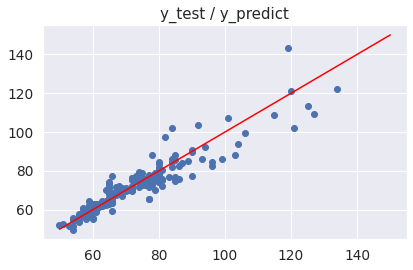

In [27]:
# Вывод графика
plt.figure()
plt.title('y_test / y_predict')
plt.scatter(y_test, y_predict)
plt.plot([50, 150], [50, 150], color="red")
plt.tight_layout()

# ИНТЕРПРЕТАЦИЯ МОДЕЛИ

`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


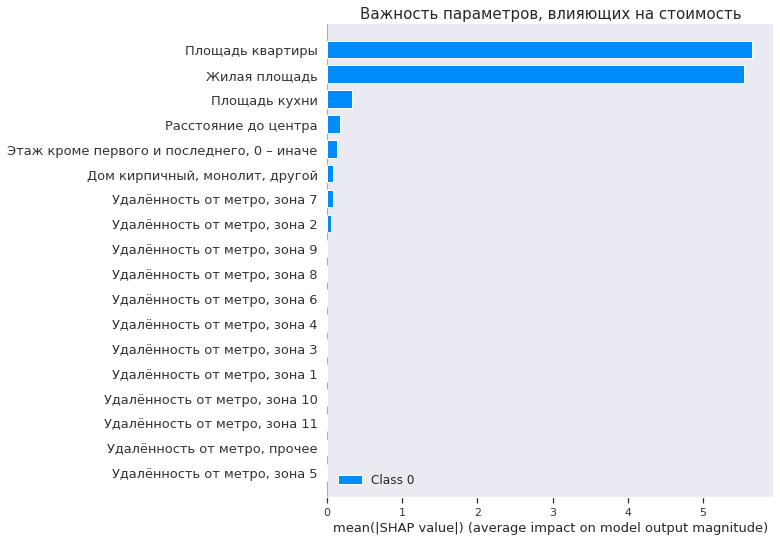

In [28]:
intrp_result = estate.interpretation(model, x_train)